In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, train_test_split
from keras.models import load_model
from keras.callbacks import EarlyStopping
from h5py._hl.dataset import sel2

In [1]:
#Functions
#데이터 호출 함수 path:경로, 경로 내의 모든 csv파일 호출출

def data_to_Input(data):
        
    data_3d = np.array([])
    data_3d = data[np.newaxis,:,:]
    data_3d = data_3d.transpose((1,2,0))
    
    return data_3d

def Pretrained_model(model_path, trainable):
    Base_model = load_model(model_path)

    for m in range(len(Base_model.layers)):
        if m in trainable:
            Base_model.layers[m].trainable = True
        else:
            Base_model.layers[m].trainable = False
            
    return Base_model

def BP_dat_plot(dat, title):
    dist_data_sbp = dat[0, :]
    dist_data_dbp = dat[1, :]

    sbp_mean = np.mean(dist_data_sbp)
    dist_data_sbp = dist_data_sbp.astype(int)

    dbp_mean = np.mean(dist_data_dbp)
    dist_data_dbp = dist_data_dbp.astype(int)

    sbp_std = np.std(dat[0, :])
    dbp_std = np.std(dat[1, :])

    fig_bp_dist, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    axs[0].hist(dist_data_sbp, bins=range(min(dist_data_sbp), max(dist_data_sbp)+2))
    axs[0].set_title(title + ' SBP')
    axs[0].axvline(x=sbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=sbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=sbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlabel('SBP value [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(sbp_mean, sbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(dist_data_dbp, bins=range(min(dist_data_dbp), max(dist_data_dbp)+2))
    axs[1].set_title(title + ' DBP')
    axs[1].axvline(x=dbp_mean, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=dbp_mean - sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=dbp_mean + sbp_std, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlabel('DBP value [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.fmmHg\nStd: %0.fmmHg'%(dbp_mean, dbp_std), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  
  # absolute error
def error_plot(y_test, y_pred):

    y_test_2d = y_test[:,:,0]
    abs_error_sbp = y_test_2d.T[:,0] - y_pred[:,0]
    abs_error_dbp = y_test_2d.T[:,1] - y_pred[:,1]

    aberr_mean_sbp = np.mean(abs_error_sbp)
    aberr_mean_dbp = np.mean(abs_error_dbp)

    aberr_std_sbp = np.std(abs_error_sbp)
    aberr_std_dbp = np.std(abs_error_dbp)

    abs_error_sbp_int = abs_error_sbp.astype(int)
    abs_error_dbp_int = abs_error_dbp.astype(int)

    fig_abs_error, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=False)

    axs[0].hist(abs_error_sbp_int, bins=range(min(abs_error_sbp_int), max(abs_error_sbp_int)+2))
    axs[0].set_title('BP-CRNN-50 SBP Error')
    axs[0].axvline(x=aberr_mean_sbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp - aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].axvline(x=aberr_mean_sbp + aberr_std_sbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[0].set_xlim([-10, 60])
    axs[0].set_xlabel('error [mmHg]')
    axs[0].set_ylabel('samples')
    axs[0].text(0.95, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_sbp, aberr_std_sbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    axs[1].hist(abs_error_dbp_int, bins=range(min(abs_error_dbp_int), max(abs_error_dbp_int)+2))
    axs[1].set_title('BP-CRNN-50 DBP Error')
    axs[1].axvline(x=aberr_mean_dbp, ymin=0, ymax=1, color = 'blue', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp - aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].axvline(x=aberr_mean_dbp + aberr_std_dbp, ymin=0, ymax=1, color = 'red', linestyle = '--')
    axs[1].set_xlim([-20, 20])
    axs[1].set_xlabel('error [mmHg]')
    axs[1].set_ylabel('samples')
    axs[1].text(2.17, 0.95, 'Mean: %0.2fmmHg\nStd: %0.2fmmHg'%(aberr_mean_dbp, aberr_std_dbp), transform=axs[0].transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
  

def bland_altman_plot(data1, data2, filename, *args, **kwargs):
    """
    Bland-Altman plot to compare two sets of measurements.

    Parameters
    ----------
    data1 : array_like
        The first set of measurements.
    data2 : array_like
        The second set of measurements.
    args : positional arguments
        Additional positional arguments to be passed to plt.scatter().
    kwargs : keyword arguments
        Additional keyword arguments to be passed to plt.scatter().

    Returns
    -------
    fig, ax : tuple
        The matplotlib figure and axes objects.
    """
    data1 = data1.T
    data2 = data2.T

    mean = np.mean([data1, data2], axis=0)
    diff = (data1 - data2)
    md = np.mean(diff, axis=1)
    sd = np.std(diff, axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5), tight_layout=False)

    ax[0].scatter(mean[0], diff[0], *args, **kwargs, alpha = 0.5)
    ax[0].axhline(md[0], color='gray', linestyle='--')
    ax[0].axhline(md[0] + 1.96*sd[0], color='red', linestyle='--')
    ax[0].axhline(md[0] - 1.96*sd[0], color='red', linestyle='--')
    ax[0].set_ylim([-30, 30])
    ax[0].set_xlabel('Mean')
    ax[0].set_ylabel('Difference')
    ax[0].set_title(filename+'SBP Bland-Altman Plot')

    ax[1].scatter(mean[1], diff[1], *args, **kwargs, alpha = 0.5)
    ax[1].axhline(md[1], color='gray', linestyle='--')
    ax[1].axhline(md[1] + 1.96*sd[1], color='red', linestyle='--')
    ax[1].axhline(md[1] - 1.96*sd[1], color='red', linestyle='--')
    ax[1].set_ylim([-30,30])
    ax[1].set_xlabel('Mean')
    ax[1].set_ylabel('Difference')
    ax[1].set_title(filename+'DBP Bland-Altman Plot')
    
    return fig, ax

def pred_plot(test_dat, pred_dat, SBP_Coef, DBP_Coef, filename):
    
    sbp_min = test_dat[:, 0].min()
    sbp_max = test_dat[:, 0].max()
    dbp_min = test_dat[:, 1].min()
    dbp_max = test_dat[:, 1].max()
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), tight_layout=False)
    
    ax[0].plot(test_dat[:, 0], np.poly1d(np.polyfit(test_dat[:, 0], pred_dat[:,0], 1))(test_dat[:, 0]), color='red')
    ax[0].scatter(test_dat[:,0], pred_dat[:,0], c='blue', alpha = 0.5)
    ax[0].text(0.95, 0.95, 'Pearson-R = %.2f'%round(SBP_Coef,2), transform=ax[0].transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax[0].set_xlim([sbp_min-10, sbp_max+10])
    ax[0].set_ylim([sbp_min-10, sbp_max+10])
    ax[0].set_xlabel('True SBP')
    ax[0].set_ylabel('Estimated SBP')
    ax[0].set_title(filename+' SBP')
    
    ax[1].plot(test_dat[:, 1], np.poly1d(np.polyfit(test_dat[:, 1], pred_dat[:,1], 1))(test_dat[:, 1]), color='red')
    ax[1].scatter(test_dat[:,1], pred_dat[:,1], c='blue', alpha = 0.5)
    ax[1].text(0.95, 0.95, 'Pearson-R = %.2f'%round(DBP_Coef,2), transform=ax[1].transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    ax[1].set_xlim([dbp_min-10, dbp_max+10])
    ax[1].set_ylim([dbp_min-10, dbp_max+10])
    ax[1].set_xlabel('True DBP')
    ax[1].set_ylabel('Estimated DBP')
    ax[1].set_title(filename+' DBP')
    
    return fig, ax

# 학습 기록
def History_plot(hist, filename):
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), tight_layout=False)
    
    ax[0].plot(hist.history["mae"])
    ax[0].plot(hist.history["val_mae"])
    ax[0].set_title(filename+' Model Mae')
    ax[0].set_ylabel("MAE")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(['Train', 'Validation'], loc='upper left')
    ax[0].grid()

    ax[1].plot(hist.history['loss'])
    ax[1].plot(hist.history['val_loss'])
    ax[1].set_title(filename+' Model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train','Validation'], loc='upper right')
    ax[1].grid()
    
    return fig, ax

In [ ]:
#Sort according to blood pressure
data_count = [100, 200, 720]

# Directory path containing the .npz files
dataset_num = int(input("Type dataset you are dealing with(0. MIMIC-III, 1. VitalDB, 2. UQ, 3. RadboudDB)"))
folder_path = input("Type dataset folder path: ")
model_name = input("Type model name: ")
save_root = input("Type save folder path: ") + "//"

filename_indx = [[15,22],[19,24],[14,20]]

# List all files in the folder
file_list = os.listdir(folder_path)

for filename in file_list:
    if filename.endswith('.npz'):  # Check if the file is an .npz file
        file_path = os.path.join(folder_path, filename)  # Get the full path of the file
        data = np.load(file_path)  # Load data from the .npz file

        x_data = data['x'][np.newaxis,:,:].transpose((1,2,0))
        y_data = data['y']
        
        for i in data_count:
            
            SBP_MAE = 100
            attempt_cnt = 0
            
            for k in range(3):

                x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 720/x_data.shape[0], train_size = i/x_data.shape[0], random_state = 0)
                x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.5, train_size = 0.5, random_state = 0)

                attempt_cnt += 1
                print(filename, "is in process...", "Used train data number:", x_train.shape[0], "attempt: ", attempt_cnt)

                # fit
                TL_model_temp = Pretrained_model(model_name, np.array([4, 5, 12, 13]))
                opt = tf.keras.optimizers.Adam(learning_rate=0.01)
                TL_model_temp.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
                callback = EarlyStopping(monitor='val_mae', patience=2000, restore_best_weights=True)
                hist_temp = TL_model_temp.fit(x_train, y_train, epochs = 20000, batch_size=32, validation_data = (x_val, y_val), verbose = 0, callbacks=[callback])
                
                # Predict on test set
                y_pred_temp = TL_model_temp.predict(x_test)
                SBP_MAE_temp = round(mean_absolute_error(y_test[:,0], y_pred_temp[:,0]),2)
                DBP_MAE_temp = round(mean_absolute_error(y_test[:,1], y_pred_temp[:,1]),2)
                
                if SBP_MAE_temp < SBP_MAE:
                    SBP_MAE = SBP_MAE_temp
                    DBP_MAE = DBP_MAE_temp
                    TL_model = TL_model_temp
                    y_pred = y_pred_temp
                    hist = hist_temp

            # 가장 잘 나온 결과를 저장
            save_folder_path_mother = save_root+filename[filename_indx[dataset_num][0]:filename_indx[dataset_num][1]]+"\\"
            save_folder_path = save_folder_path_mother+str(i//2)+"\\"

            # Create a new folder
            if not os.path.exists(save_folder_path_mother):
                os.mkdir(save_folder_path_mother)
            if not os.path.exists(save_folder_path):
                os.mkdir(save_folder_path)
                
            SBP_Coef = round(np.corrcoef(y_test[:, 0], y_pred[:,0])[0, 1],2)
            DBP_Coef = round(np.corrcoef(y_test[:, 1], y_pred[:,1])[0, 1],2)

            #Text파일로 결과 저장
            with open(save_folder_path+"Result.txt", 'w') as file:
                file.write("Used Data number for train: " + str(x_train.shape[0]) + ", validation: "+ str(x_val.shape[0]) + "\n")
                file.write("MAE of SBP: " +str(SBP_MAE)+"\n")
                file.write("MAE of DBP: " +str(DBP_MAE)+"\n")
                file.write("Pearson-R of SBP: " +str(SBP_Coef)+"\n")
                file.write("Pearson-R of DBP: " +str(DBP_Coef)+"\n")

            fig_ba, ax_ba = bland_altman_plot(y_test, y_pred, filename[filename_indx[dataset_num][0]:filename_indx[dataset_num][1]], color='blue', marker='o')
            fig_ba.savefig(save_folder_path+filename[filename_indx[dataset_num][0]:filename_indx[dataset_num][1]]+'_Bland_Altman.png')
            plt.close(fig_ba)
            fig_ac, ax_ac = pred_plot(y_test, y_pred, SBP_Coef, DBP_Coef, filename[filename_indx[dataset_num][0]:filename_indx[dataset_num][1]])
            fig_ac.savefig(save_folder_path+filename[filename_indx[dataset_num][0]:filename_indx[dataset_num][1]]+'_Pearson_R.png')
            plt.close(fig_ac)
            fig_history, ax_history = History_plot(hist, filename[filename_indx[dataset_num][0]:filename_indx[dataset_num][1]])
            fig_history.savefig(save_folder_path+filename[filename_indx[dataset_num][0]:filename_indx[dataset_num][1]]+'_History.png')
            plt.close(fig_history)
            TL_model.save(save_folder_path+filename[filename_indx[dataset_num][0]:filename_indx[dataset_num][1]] + "_" + str(i/2) + 'TL_model.h5')
        
        data.close()

Type dataset you are dealing with(0. MIMIC-III, 1. VitalDB, 2. UQ, 3. RadboudDB) 0
Type dataset folder path:  D:\김윤철\Dataset\Ex_3\MIMIC-III dataset\Group_1
Type model name:  D:\김윤철\Models\Ex_3\VitalDB\Collective\V1H50PG1.h5
Type save folder path:  D:\김윤철\Models\Ex_3\V1H50G1_to_MG1


processed_data_p023762.npz is in process... Used train data number: 50 attempt:  1
23/23 [==============================] - 0s 5ms/step
processed_data_p023762.npz is in process... Used train data number: 50 attempt:  2
23/23 [==============================] - 1s 6ms/step
processed_data_p023762.npz is in process... Used train data number: 50 attempt:  3
23/23 [==============================] - 1s 6ms/step
processed_data_p023762.npz is in process... Used train data number: 100 attempt:  1
23/23 [==============================] - 1s 6ms/step
processed_data_p023762.npz is in process... Used train data number: 100 attempt:  2
23/23 [==============================] - 1s 5ms/step
processed_data_p023762.npz is in process... Used train data number: 100 attempt:  3
23/23 [==============================] - 0s 5ms/step
processed_data_p023762.npz is in process... Used train data number: 360 attempt:  1
23/23 [==============================] - 0s 5ms/step
processed_data_p023762.npz is in process... 

In [ ]:
Type dataset you are dealing with(0. MIMIC-III, 1. VitalDB, 2. UQ, 3. RadboudDB) 0
Type dataset folder path:  D:\김윤철\Dataset\Ex_3\MIMIC-III dataset\Group_1
Type model name:  D:\김윤철\Models\Ex_3\VitalDB\Collective\V1H50PG1.h5
Type save folder path:  D:\김윤철\Models\Ex_3\V1H50G1_to_MG1

In [9]:
data.close()

In [4]:
# 특정 데이터 재학습 시키고 싶은 경우, 데이터 이름 입력하면 세 번씩 재학습
#Sort according to blood pressure
data_count = [100]

# Directory path containing the .npz files
folder_path = 'F:\\Lab\\Research\\NIBP_PPG\\Dataset\\Ex_1\\Attempt_2\\Processed_dataset\\Group_2\\'

filename = input("Type full patient number: ")
file_path = os.path.join(folder_path, filename)  # Get the full path of the file
data = np.load(file_path)  # Load data from the .npz file

#Data load
#data = np.load(folder_path+sub_name)

x_data = data['x'][np.newaxis,:,:].transpose((1,2,0))
y_data = data['y']

for i in data_count:

    SBP_MAE = 100

    for k in range(3):

        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, train_size = i/7200, random_state = 0)
        x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.5, train_size = 0.5, random_state = 0)

        print("Used train data number:", x_train.shape[0])
        print("Used test data number:", x_test.shape[0])

        # fit
        TL_model_temp = Pretrained_model('F:\\Lab\\Research\\NIBP_PPG\\Models\\Ex_1\\Attempt_2\\Collective\\Collective_Model_5h_G1_v2.2.h5', np.array([4, 5, 12, 13]))
        opt = tf.keras.optimizers.Adam(learning_rate=0.01)
        TL_model_temp.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
        callback = EarlyStopping(monitor='val_mae', patience=2000, restore_best_weights=True)
        hist_temp = TL_model_temp.fit(x_train, y_train, epochs = 20000, batch_size=32, validation_data = (x_val, y_val), verbose = 0, callbacks=[callback])

        # Predict on test set
        y_pred_temp = TL_model_temp.predict(x_test)
        SBP_MAE_temp = round(mean_absolute_error(y_test[:,0], y_pred_temp[:,0]),2)
        DBP_MAE_temp = round(mean_absolute_error(y_test[:,1], y_pred_temp[:,1]),2)

        if SBP_MAE_temp < SBP_MAE:
            SBP_MAE = SBP_MAE_temp
            DBP_MAE = DBP_MAE_temp
            TL_model = TL_model_temp
            y_pred = y_pred_temp
            hist = hist_temp

    # 가장 잘 나온 결과를 저장
    save_folder_path_mother = 'F:\\Lab\\Research\\NIBP_PPG\\Models\\Ex_1\\Attempt_3\\'+filename[15:22]+"\\"
    save_folder_path = 'F:\\Lab\\Research\\NIBP_PPG\\Models\\Ex_1\\Attempt_3\\'+filename[15:22]+"\\"+str(i)+"\\"

    # Create a new folder
    if not os.path.exists(save_folder_path_mother):
        os.mkdir(save_folder_path_mother)
    if not os.path.exists(save_folder_path):
        os.mkdir(save_folder_path)
        
    SBP_Coef = round(np.corrcoef(y_test[:, 0], y_pred[:,0])[0, 1],2)
    DBP_Coef = round(np.corrcoef(y_test[:, 1], y_pred[:,1])[0, 1],2)

    with open(save_folder_path+"Result_retrain.txt", 'w') as file:
        file.write("Used Data number for train: " + str(x_train.shape[0]) + ", validation: "+ str(x_val.shape[0]) + "\n")
        file.write("MAE of SBP: " +str(SBP_MAE)+"\n")
        file.write("MAE of DBP: " +str(DBP_MAE)+"\n")
        file.write("Pearson-R of SBP: " +str(SBP_Coef)+"\n")
        file.write("Pearson-R of DBP: " +str(DBP_Coef)+"\n")

    fig_ba, ax_ba = bland_altman_plot(y_test, y_pred, filename[15:22], color='blue', marker='o')
    fig_ba.savefig(save_folder_path+filename[15:22]+'_Bland_Altman_retrain.png')
    fig_ac, ax_ac = pred_plot(y_test, y_pred, SBP_Coef, DBP_Coef, filename[15:22])
    fig_ac.savefig(save_folder_path+filename[15:22]+'_Pearson_R_retrain.png')

    #Save learning history and model
    fig_history, ax_history = History_plot(hist, filename[15:22])
    fig_history.savefig(save_folder_path+filename[15:22]+'_History_retrain.png')
    TL_model.save(save_folder_path+filename[15:22] + "_" + str(i) + 'TL_model_retrain.h5')

data.close()

Type full patient number: processed_data_p040934.npz
Used train data number: 50
Used test data number: 720
23/23 [==============================] - 2s 63ms/step
Used train data number: 50
Used test data number: 720
23/23 [==============================] - 2s 49ms/step
Used train data number: 50
Used test data number: 720
23/23 [==============================] - 2s 50ms/step


NameError: name 'SBP_Coef' is not defined

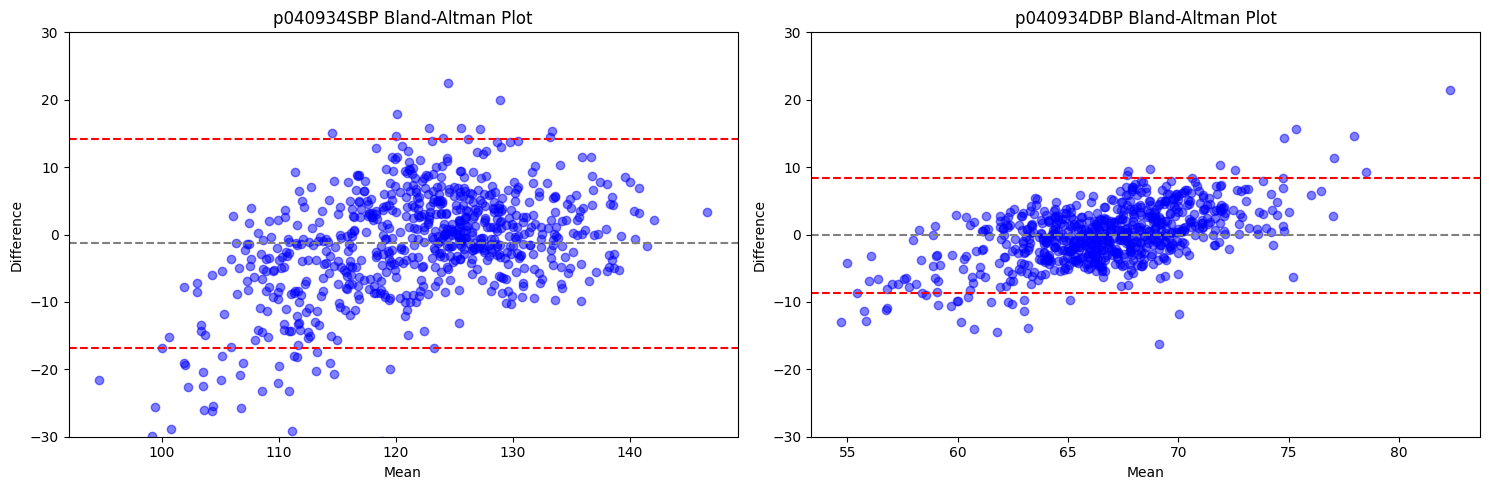

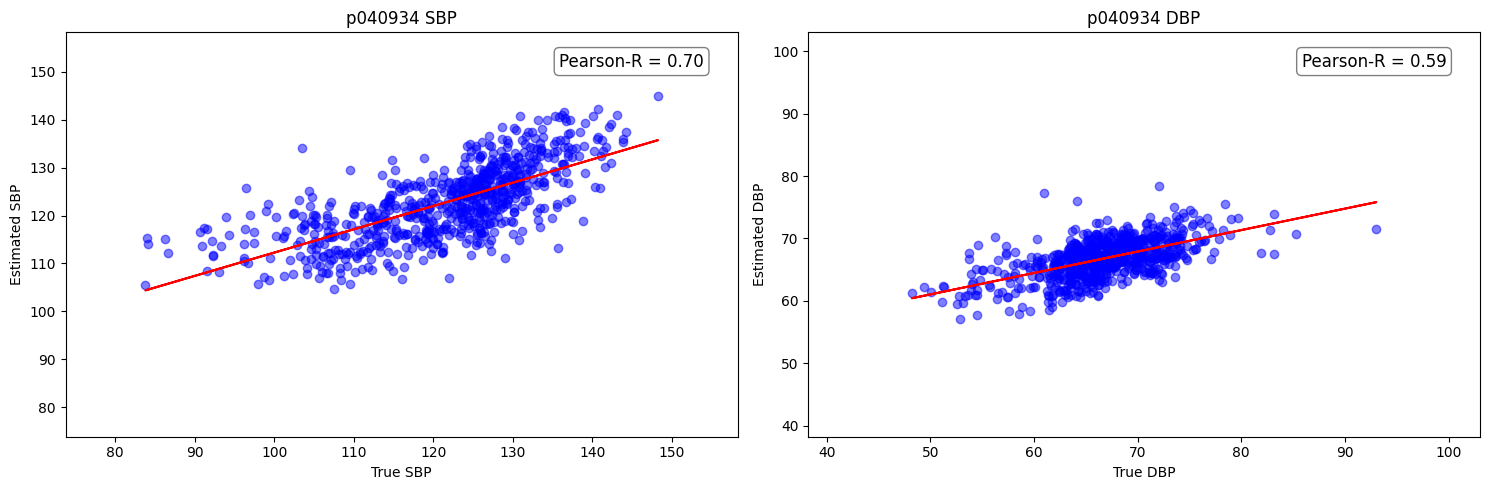

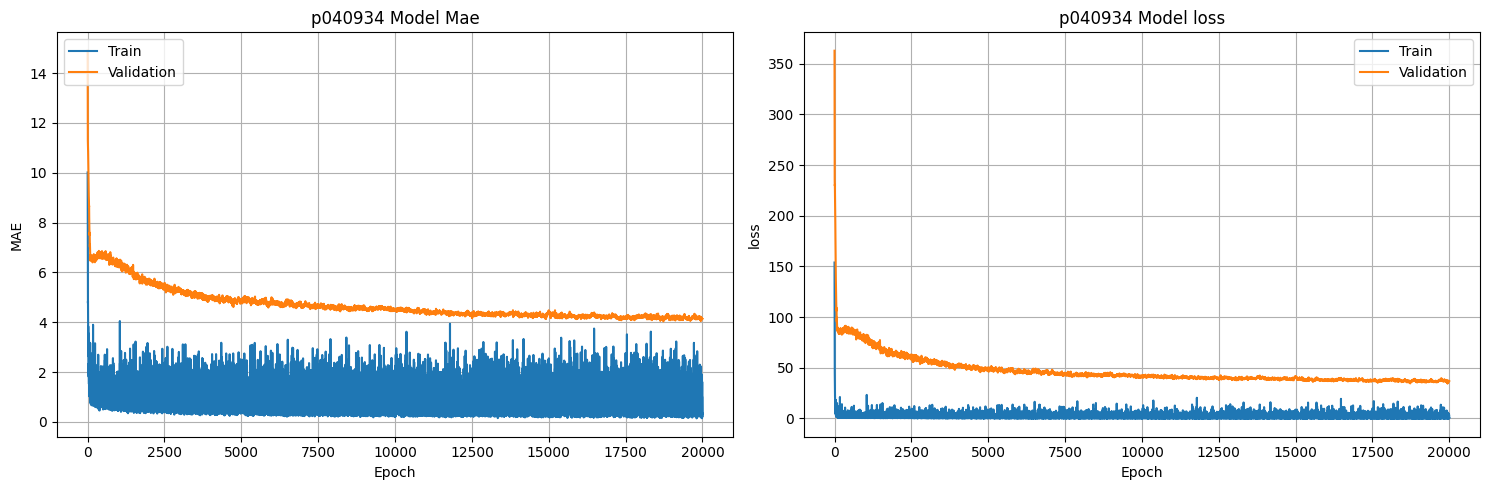

In [6]:
SBP_Coef = round(np.corrcoef(y_test[:, 0], y_pred[:,0])[0, 1],2)
DBP_Coef = round(np.corrcoef(y_test[:, 1], y_pred[:,1])[0, 1],2)

with open(save_folder_path+"Result_retrain.txt", 'w') as file:
    file.write("Used Data number for train: " + str(x_train.shape[0]) + ", validation: "+ str(x_val.shape[0]) + "\n")
    file.write("MAE of SBP: " +str(SBP_MAE)+"\n")
    file.write("MAE of DBP: " +str(DBP_MAE)+"\n")
    file.write("Pearson-R of SBP: " +str(SBP_Coef)+"\n")
    file.write("Pearson-R of DBP: " +str(DBP_Coef)+"\n")

fig_ba, ax_ba = bland_altman_plot(y_test, y_pred, filename[15:22], color='blue', marker='o')
fig_ba.savefig(save_folder_path+filename[15:22]+'_Bland_Altman_retrain.png')
fig_ac, ax_ac = pred_plot(y_test, y_pred, SBP_Coef, DBP_Coef, filename[15:22])
fig_ac.savefig(save_folder_path+filename[15:22]+'_Pearson_R_retrain.png')

#Save learning history and model
fig_history, ax_history = History_plot(hist, filename[15:22])
fig_history.savefig(save_folder_path+filename[15:22]+'_History_retrain.png')
TL_model.save(save_folder_path+filename[15:22] + "_" + str(i) + 'TL_model_retrain.h5')